In [1]:
pip install wikipedia-api

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.7.1-py3-none-any.whl size=14347 sha256=f8aceb6c63eb191dbba6e79d2d59f9b428081ca7e65358049a3c2eed75fb8dae
  Stored in directory: /root/.cache/pip/wheels/4c/96/18/b9201cc3e8b47b02b510460210cfd832ccf10c0c4dd0522962
Successfully built wikipedia-api


In [2]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.6 MB/s eta 0:00:00


In [3]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [4]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm
import itertools

import nltk
nltk.download('punkt')
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
import wikipediaapi
import time
from requests.exceptions import ReadTimeout
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##Data Genaration

In [ ]:
# Load the FEVER dataset with a specific configuration and trust remote code
dataset = load_dataset("fever", "v1.0", trust_remote_code=True)

In [ ]:
train_df = pd.DataFrame(dataset['train'][:50000])
dev_df = pd.DataFrame(dataset['labelled_dev'][:5000])
test_df = pd.DataFrame(dataset['paper_test'][:5000])

In [ ]:
len(train_df)

In [ ]:
user_agent = "YourAppName/1.0 (https://yourappwebsite.com; contact@yourappemail.com)"
wiki_wiki = wikipediaapi.Wikipedia('en', headers={'User-Agent': user_agent})

def get_evidence_text(row):
    evidence_texts = []
    wiki_url = row.get('evidence_wiki_url', '')
    sentence_id = row.get('evidence_sentence_id', 0)

    if wiki_url:
        page_title = wiki_url.split('/wiki/')[-1]
        for _ in range(2):
            try:
                page = wiki_wiki.page(page_title)
                if page.exists():
                    sentences = page.text.split('. ')
                    if sentence_id < len(sentences):
                        evidence_texts.append(sentences[sentence_id])
                    else:
                        evidence_texts.append("Sentence ID out of range")
                else:
                    evidence_texts.append("Page not found or query failed")
                break
            except ReadTimeout:
                print(f"ReadTimeout error occurred for page {page_title}. Retrying...")
                time.sleep(2)
        else:
            evidence_texts.append("Failed to fetch page after retries")
    else:
        evidence_texts.append("Invalid Wikipedia URL")

    return evidence_texts


In [ ]:
train_df['Evidence'] = train_df.apply(get_evidence_text, axis=1)
print(train_df[['claim', 'Evidence']].head())

In [ ]:
dev_df['Evidence'] = dev_df.apply(get_evidence_text, axis=1)
print(dev_df[['claim', 'Evidence']].head())
test_df['Evidence'] = dev_df.apply(get_evidence_text, axis=1)
print(test_df[['claim', 'Evidence']].head())

In [ ]:
train_df_new = train_df[~train_df['Evidence'].apply(lambda x: any(item in ['Invalid Wikipedia URL', 'Page not found or query failed'] for item in x))]
dev_df_new = dev_df[~dev_df['Evidence'].apply(lambda x: any(item in ['Invalid Wikipedia URL', 'Page not found or query failed'] for item in x))]
test_df_new = test_df[~test_df['Evidence'].apply(lambda x: any(item in ['Invalid Wikipedia URL', 'Page not found or query failed'] for item in x))]

In [ ]:
train_df.rename(columns={
    'claim': 'Claim',
    'evidence_id': 'ID'
}, inplace=True)

train_df = train_df[['Claim', 'Evidence', 'ID', 'Label']]
train_df.to_csv('train_pairs.csv', index=False)
print("File saved successfully as 'train_pairs.csv'")
dev_df.rename(columns={
    'claim': 'Claim',
    'evidence_id': 'ID'
}, inplace=True)
dev_df = dev_df[['Claim', 'Evidence', 'ID', 'Label']]
dev_df.to_csv('val_pairs.csv', index=False)
print("File saved successfully as 'val_pairs.csv'")
test_df.rename(columns={
    'claim': 'Claim',
    'evidence_id': 'ID'
}, inplace=True)
test_df = test_df[['Claim', 'Evidence', 'ID', 'Label']]
test_df.to_csv('test_pairs.csv', index=False)
print("File saved successfully as 'test_pairs.csv'")

##Data Preprocessing

In [144]:
train_df = pd.read_csv('/content/test_pairs.csv')
val_df = pd.read_csv('/content/val_pairs.csv')
test_df = pd.read_csv('/content/test_pairs.csv')

In [145]:
train_df = train_df.sample(n=10000,replace=True)
val_df = val_df.sample(n=1000,replace=True)
test_df = test_df.sample(n=1000,replace=True)

# Check the shape of the DataFrames to confirm
print(f"Training data shape: {train_df.shape}")
print(f"Validation data shape: {val_df.shape}")
print(f"Test data shape: {test_df.shape}")

Training data shape: (10000, 5)
Validation data shape: (1000, 5)
Test data shape: (1000, 5)


In [146]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [147]:
train_df.head(5)

,Unnamed: 0,Claim,Evidence,ID,Label
0,3814,Chris Bosh won his first NBA Finals title in 2...,8\tBosh won his first NBA title after Miami de...,107273,SUPPORTS
1,7039,Michael Hutchence has yet to die.,0\tMichael Kelland John Hutchence -LRB- 22 Jan...,97957,REFUTES
2,6430,1635 is the year when the widow of Henry Conde...,"55\tHis widow , Elizabeth , was buried there o...",14693,SUPPORTS
3,4263,Alex Jones was born in 1973.,0\tAlexander Emerick Jones -LRB- born February...,108198,REFUTES
4,4310,Bonobos live south of the river.,"12\tBonobos live south of the river , and ther...",26381,SUPPORTS


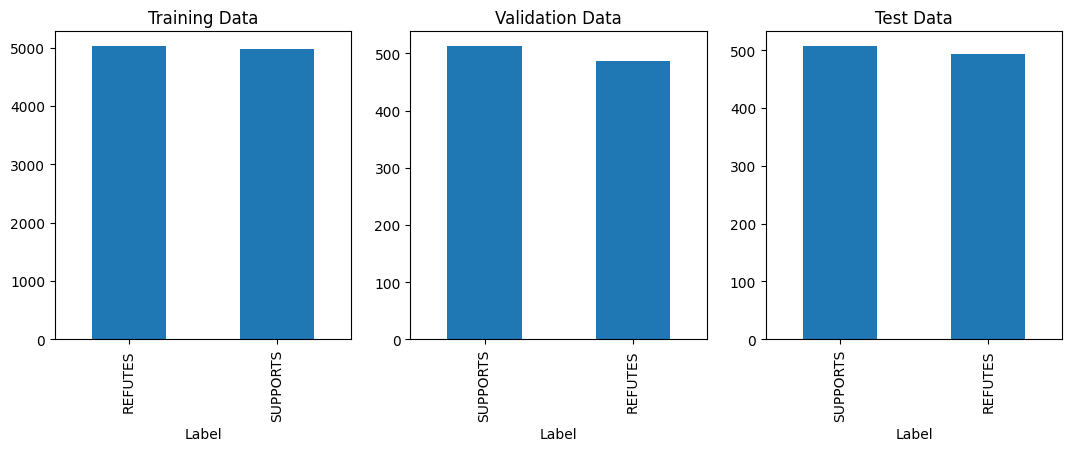

In [148]:
# plot the distribution of the labels
fig = plt.figure(figsize=(13, 4))
fig.add_subplot(131)
ax1 = train_df['Label'].value_counts().plot(kind='bar')
ax1.set_title('Training Data')
fig.add_subplot(132)
ax2 = val_df['Label'].value_counts().plot(kind='bar')
ax2.set_title('Validation Data')
fig.add_subplot(133)
ax3 = test_df['Label'].value_counts().plot(kind='bar')
ax3.set_title('Test Data')
plt.show()

In [149]:
REPLACE_BY_SPACE_RE = re.compile(r'[/(){}\[\]\|@`\']')
REMOVE_BEGINNING_EVIDENCES_RE = re.compile(r'\b[0-9]{1,}\t')
REMOVE_END_EVIDENCES_RE = re.compile(r'\.\t.*\b')
SPLIT_COMPOUND_RE = re.compile(r'\w+(-)\w+')
REMOVE_ROUNDED_BRACKETS_RE = re.compile(r'-LRB-|-RRB-')
REMOVE_BETWEEN_SQUARE_BRACKETS_RE = re.compile(r'-LSB-(.*?)-RSB-')
GOOD_SYMBOLS_RE = re.compile(r'[^0-9a-z \.;]')

def preprocess_text(text: str, column_type: str) -> str:

    if column_type == 'Evidence':
        text = REMOVE_BEGINNING_EVIDENCES_RE.sub('', text)
        text = REMOVE_END_EVIDENCES_RE.sub('', text)
        text = REMOVE_ROUNDED_BRACKETS_RE.sub('', text)
        text = REMOVE_BETWEEN_SQUARE_BRACKETS_RE.sub('', text)


    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = SPLIT_COMPOUND_RE.sub(' ', text)
    text = GOOD_SYMBOLS_RE.sub('', text)
    text = text.strip()

    return text


train_df['Claim'] = train_df['Claim'].apply(lambda txt: preprocess_text(txt, 'Claim'))
train_df['Evidence'] = train_df['Evidence'].apply(lambda txt: preprocess_text(txt, 'Evidence'))

val_df['Claim'] = val_df['Claim'].apply(lambda txt: preprocess_text(txt, 'Claim'))
val_df['Evidence'] = val_df['Evidence'].apply(lambda txt: preprocess_text(txt, 'Evidence'))

test_df['Claim'] = test_df['Claim'].apply(lambda txt: preprocess_text(txt, 'Claim'))
test_df['Evidence'] = test_df['Evidence'].apply(lambda txt: preprocess_text(txt, 'Evidence'))

print('Preprocessing completed!')

Preprocessing completed!


##Create data for model

In [100]:
# Custom Dataset Class
class FactCheckingDataset(Dataset):
    def __init__(self, claims, evidence, labels, tokenizer, max_len=512):
        self.claims = claims
        self.evidence = evidence
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        claim = self.claims[idx]
        evidence = self.evidence[idx]
        label = self.labels[idx]

        # Define label mapping
        label_mapping = {'SUPPORTS': 0, 'REFUTES': 1}
        # Map string labels to integers
        label = label_mapping[label]

        # Tokenize input text
        inputs = self.tokenizer.encode_plus(
            claim,
            evidence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        # Reshape input tensors and return
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = torch.tensor(label, dtype=torch.long)

        return inputs

In [150]:
class FactCheckingDataset(Dataset):
    def __init__(self, claims, evidence, labels, tokenizer, max_len=512):
        self.claims = claims
        self.evidence = evidence
        self.labels = labels  # Assuming labels are already numeric
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.claims)

    def __getitem__(self, idx):
        claim = self.claims[idx]
        evidence = self.evidence[idx]
        label = self.labels[idx]  # Use the numeric label directly

        # Tokenize input text
        inputs = self.tokenizer.encode_plus(
            claim,
            evidence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        # Reshape input tensors and return
        inputs = {key: val.squeeze(0) for key, val in inputs.items()}
        inputs['labels'] = torch.tensor(label, dtype=torch.long)

        return inputs


In [151]:
# Prepare Data
label_mapping = {'SUPPORTS': 0, 'REFUTES': 1}
test_df['Numeric_Label'] = test_df['Label'].map(label_mapping)
test_labels = test_df['Numeric_Label'].tolist()
train_df['Numeric_Label'] = train_df['Label'].map(label_mapping)
train_labels = train_df['Numeric_Label'].tolist()
val_df['Numeric_Label'] = val_df['Label'].map(label_mapping)

val_labels = val_df['Numeric_Label'].tolist()
train_claims = train_df['Claim'].tolist()
train_evidence = train_df['Evidence'].tolist()
val_claims = val_df['Claim'].tolist()
val_evidence = val_df['Evidence'].tolist()
test_claims = test_df['Claim'].tolist()
test_evidence = test_df['Evidence'].tolist()

##BERT Model training

In [152]:
# Load pre-trained BERT tokenizer and model
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Create datasets
train_dataset = FactCheckingDataset(train_claims, train_evidence, train_labels, tokenizer_bert)
val_dataset = FactCheckingDataset(val_claims, val_evidence, val_labels, tokenizer_bert)
test_dataset = FactCheckingDataset(test_claims, test_evidence, test_labels, tokenizer_bert)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [153]:
# Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [154]:
# Trainer for BERT
bert_trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the BERT model
bert_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.270700,0.356646
2,0.101200,0.438777
3,0.117100,0.515856


TrainOutput(global_step=939, training_loss=0.23372979197131433, metrics={'train_runtime': 615.4399, 'train_samples_per_second': 48.746, 'train_steps_per_second': 1.526, 'total_flos': 7893331660800000.0, 'train_loss': 0.23372979197131433, 'epoch': 3.0})

In [155]:
bert_predictions = bert_trainer.predict(test_dataset)
bert_preds = bert_predictions.predictions.argmax(-1)
bert_accuracy = accuracy_score(test_labels, bert_preds)
print(f"BERT Accuracy: {bert_accuracy}")

BERT Accuracy: 0.961


##RoBERTa Model training

In [156]:
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

train_dataset_RoBERTa = FactCheckingDataset(train_claims, train_evidence, train_labels, tokenizer_roberta)
val_dataset_RoBERTa = FactCheckingDataset(val_claims, val_evidence, val_labels, tokenizer_roberta)
test_dataset_RoBERTa = FactCheckingDataset(test_claims, test_evidence, test_labels, tokenizer_roberta)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [157]:
# Initialize the Trainer for RoBERTa
roberta_trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=train_dataset_RoBERTa,
    eval_dataset=val_dataset_RoBERTa
)

# Train the RoBERTa model
roberta_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.247900,0.369333
2,0.189400,0.408534
3,0.120100,0.455274


TrainOutput(global_step=939, training_loss=0.2444904277753779, metrics={'train_runtime': 687.5013, 'train_samples_per_second': 43.636, 'train_steps_per_second': 1.366, 'total_flos': 7893331660800000.0, 'train_loss': 0.2444904277753779, 'epoch': 3.0})

In [29]:
import torch

# Clear cache memory in PyTorch
torch.cuda.empty_cache()
import gc


del train_dataset
del val_dataset

# Run garbage collector
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()


In [158]:
roberta_predictions = roberta_trainer.predict(test_dataset_RoBERTa)
roberta_preds = roberta_predictions.predictions.argmax(-1)
roberta_accuracy = accuracy_score(test_labels, roberta_preds)
print(f"RoBERTa Accuracy: {roberta_accuracy}")

RoBERTa Accuracy: 0.96


##XLNet Model training

In [159]:
tokenizer_xlnet = XLNetTokenizer.from_pretrained('xlnet-base-cased')
xlnet_model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)

train_dataset_XLNet = FactCheckingDataset(train_claims, train_evidence, train_labels, tokenizer_xlnet)
val_dataset_XLNet = FactCheckingDataset(val_claims, val_evidence, val_labels, tokenizer_xlnet)
test_dataset_XLNet = FactCheckingDataset(test_claims, test_evidence, test_labels, tokenizer_xlnet)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [160]:
# Trainer for XLNet
xlnet_trainer = Trainer(
    model=xlnet_model,
    args=training_args,
    train_dataset=train_dataset_XLNet,
    eval_dataset=val_dataset_XLNet
)

# Train the XLNet model
xlnet_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.272900,0.429831
2,0.164900,0.543408
3,0.070100,0.554187


TrainOutput(global_step=939, training_loss=0.27226683944939806, metrics={'train_runtime': 1482.1427, 'train_samples_per_second': 20.241, 'train_steps_per_second': 0.634, 'total_flos': 8546408386560000.0, 'train_loss': 0.27226683944939806, 'epoch': 3.0})

In [161]:
xlnet_predictions = xlnet_trainer.predict(test_dataset_XLNet)
xlnet_preds = xlnet_predictions.predictions.argmax(-1)
xlnet_accuracy = accuracy_score(test_labels, xlnet_preds)
print(f"XLNet Accuracy: {xlnet_accuracy}")

XLNet Accuracy: 0.959


##Accuracy measurements

In [162]:
# Print classification reports
print("BERT Classification Report:\n", classification_report(test_df['Numeric_Label'], bert_preds, target_names=label_mapping))
print("RoBERTa Classification Report:\n", classification_report(test_df['Numeric_Label'], roberta_preds, target_names=label_mapping))
print("XLNet Classification Report:\n", classification_report(test_df['Numeric_Label'], xlnet_preds, target_names=label_mapping))


BERT Classification Report:
               precision    recall  f1-score   support

    SUPPORTS       0.96      0.97      0.96       507
     REFUTES       0.97      0.96      0.96       493

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

RoBERTa Classification Report:
               precision    recall  f1-score   support

    SUPPORTS       0.97      0.95      0.96       507
     REFUTES       0.95      0.97      0.96       493

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

XLNet Classification Report:
               precision    recall  f1-score   support

    SUPPORTS       0.96      0.96      0.96       507
     REFUTES       0.96      0.96      0.96       493

    accuracy                           0.96      1000
   macro avg       0.96      0.96    

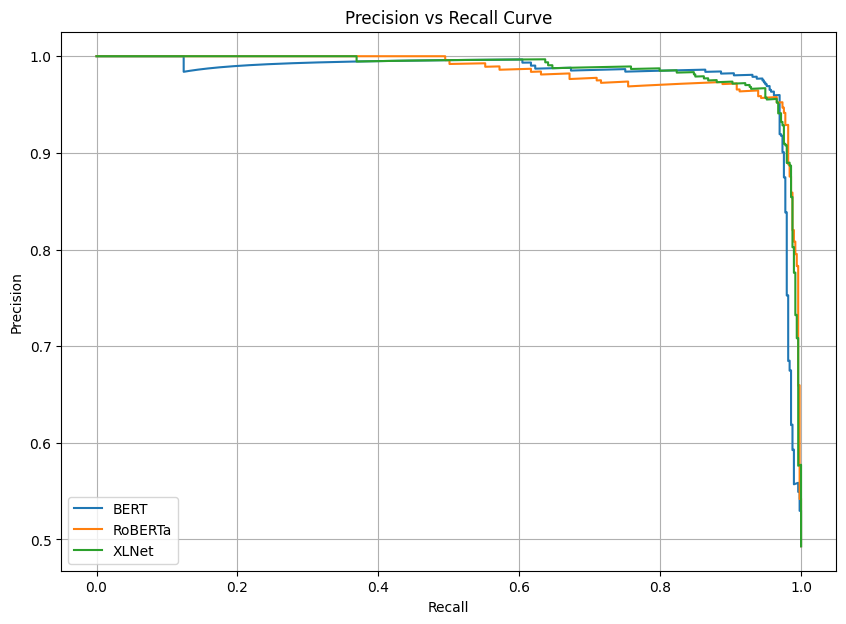

In [165]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report

# Assuming predictions and true labels are available from earlier steps

# BERT Precision-Recall
bert_precision, bert_recall, _ = precision_recall_curve(test_df['Numeric_Label'], bert_predictions.predictions[:, 1])

# RoBERTa Precision-Recall
roberta_precision, roberta_recall, _ = precision_recall_curve(test_df['Numeric_Label'], roberta_predictions.predictions[:, 1])

# XLNet Precision-Recall
xlnet_precision, xlnet_recall, _ = precision_recall_curve(test_df['Numeric_Label'], xlnet_predictions.predictions[:, 1])

# Plot Precision-Recall Curve
plt.figure(figsize=(10, 7))
plt.plot(bert_recall, bert_precision, label='BERT')
plt.plot(roberta_recall, roberta_precision, label='RoBERTa')
plt.plot(xlnet_recall, xlnet_precision, label='XLNet')

# Add labels and legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


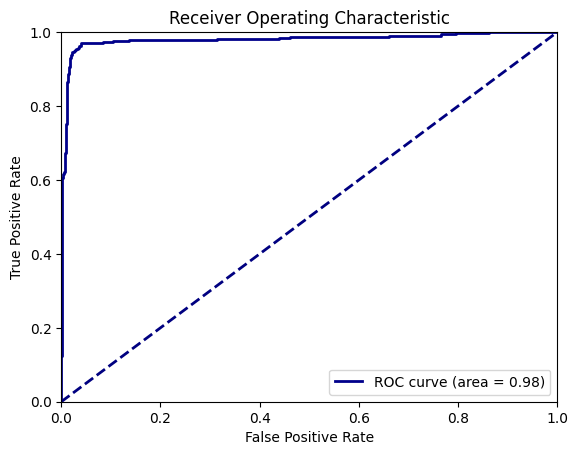

In [169]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_true contains true labels and y_pred_proba contains predicted probabilities for the positive class

fpr, tpr, _ = roc_curve(test_df['Numeric_Label'], bert_predictions.predictions[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


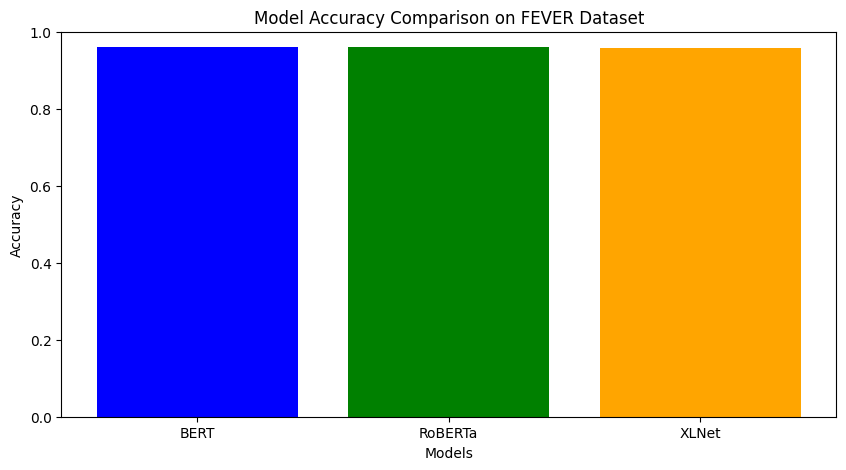

In [163]:
# Plot accuracy comparison
models = ['BERT', 'RoBERTa', 'XLNet']
accuracies = [bert_accuracy, roberta_accuracy, xlnet_accuracy]

plt.figure(figsize=(10, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.ylim([0, 1])
plt.title('Model Accuracy Comparison on FEVER Dataset')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()

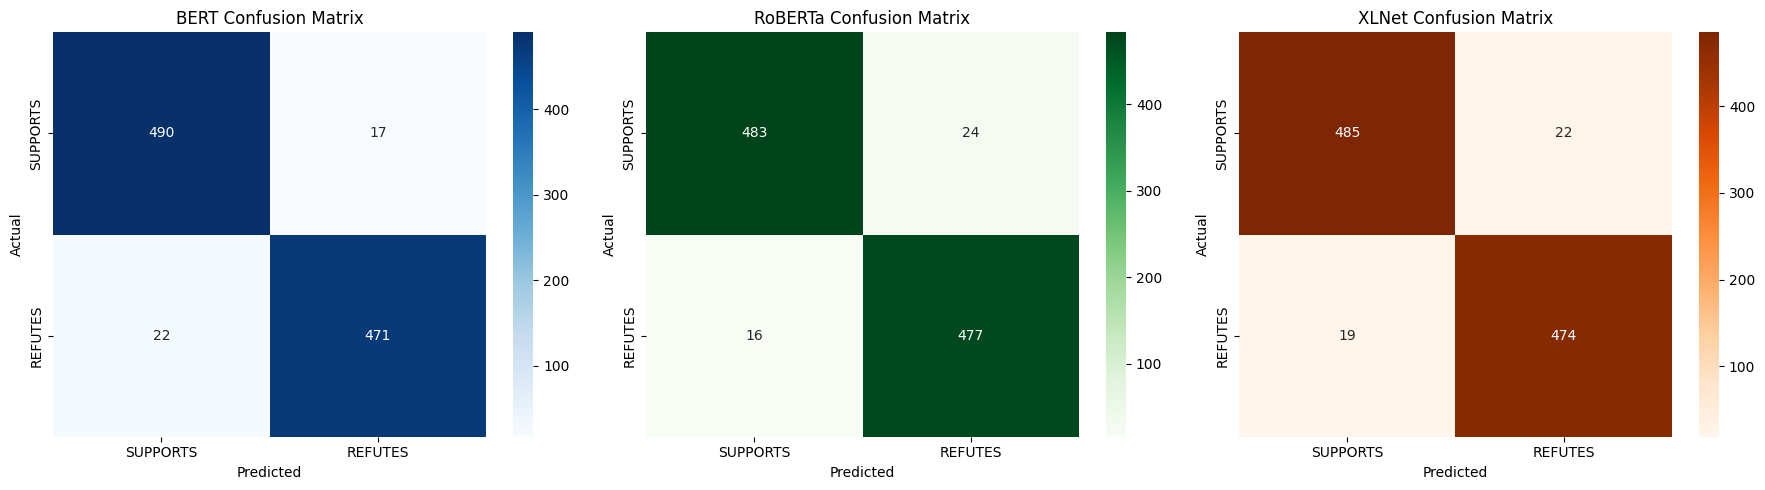

In [164]:
# Plot confusion matrices
bert_cm = confusion_matrix(test_labels, bert_preds)
roberta_cm = confusion_matrix(test_labels, roberta_preds)
xlnet_cm = confusion_matrix(test_labels, xlnet_preds)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# BERT
sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=label_mapping, yticklabels=label_mapping)
axes[0].set_title('BERT Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# # RoBERTa
sns.heatmap(roberta_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], xticklabels=label_mapping, yticklabels=label_mapping)
axes[1].set_title('RoBERTa Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# # XLNet
sns.heatmap(xlnet_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[2], xticklabels=label_mapping, yticklabels=label_mapping)
axes[2].set_title('XLNet Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()
